### Part 1. Data Acquisition & Preprocessing
#### Staring with incorperating the dataset

In [1]:
%pip install kaggle -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing all neccessary frameworks

import numpy as np
import torch


from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize, scale, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

#%load_ext cudf.pandas
import pandas as pd
from cuml.manifold import UMAP
from cuml.cluster import hdbscan
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

import warnings
warnings.filterwarnings('ignore')

In [3]:
%%bash
# Downloading the dataset from Kaggle

export KAGGLE_USERNAME=orranereid
export KAGGLE_KEY=395c5483c47968f4a9e8ea5ac326f64f

#kaggle datasets download -d elvinrustam/books-dataset --unzip --force

# Preproccessing Data Steps.

**Data Sources**

From Kaggle, we were able to use a Book Dataset with over 100,000 observations. It includes multiple features such as authors, genres, titles, & date of publication.

In [4]:
# Extracting the info from the CSV fiel
gb_md = pd.read_csv('BooksDataset.csv')

In [5]:
# Here we are printing the original data from the csv
gb_md

,Title,Authors,Description,Category,Publisher,Publish Date,Price
0,Goat Brothers,"By Colton, Larry",NaN,"History , General",Doubleday,"Friday, January 1, 1993",Price Starting at $8.79
1,The Missing Person,"By Grumbach, Doris",NaN,"Fiction , General",Putnam Pub Group,"Sunday, March 1, 1981",Price Starting at $4.99
2,Don't Eat Your Heart Out Cookbook,"By Piscatella, Joseph C.",NaN,"Cooking , Reference",Workman Pub Co,"Thursday, September 1, 1983",Price Starting at $4.99
3,When Your Corporate Umbrella Begins to Leak: A...,"By Davis, Paul D.",NaN,NaN,Natl Pr Books,"Monday, April 1, 1991",Price Starting at $4.99
4,Amy Spangler's Breastfeeding : A Parent's Guide,"By Spangler, Amy",NaN,NaN,Amy Spangler,"Saturday, February 1, 1997",Price Starting at $5.32
...,...,...,...,...,...,...,...
103077,Build 3 Super Serving Carts,By Chuck Hampton,NaN,NaN,ENDesigns Inc.,"Wednesday, January 1, 1992",Price Starting at $9.97
103078,My Land of Israel,"By Nover, Elizabeth Z.",NaN,"Juvenile Nonfiction , People & Places , Middl...",Behrman House,"Friday, May 1, 1987",Price Starting at $4.99
103079,Tongues: To Speak or Not to Speak,By Donald W. Burdick,NaN,NaN,Moody Press,"Wednesday, January 1, 1969",Price Starting at $5.29
103080,If I'm in charge here why is everybody laughing?,"By Campbell, David P.",NaN,NaN,Argus Communications,"Tuesday, January 1, 1980",Price Starting at $4.99


**Data Cleaning and Preprocessing**

In this step, we will remove any noisy data with inconsistencies and missing values. Then, we will modify our data by applying tokenization techniques.

In [6]:
# Dropping all observations with missing values
gb_md = gb_md.dropna()

# Now we will be dropping features that are irrelevant for us
gb_md = gb_md.drop(columns=['Price', 'Publisher'])


In [7]:
# Modifying the values in Publish Date to only keep the year
gb_md['Publish Date'] = gb_md['Publish Date'].str.slice(-4)

# Removing the value 'General' from the 'Categories' feature in order to avoid bad clusterings
gb_md['Category'] = gb_md['Category'].str.replace('General', '', regex=False)
gb_md['Category'] = gb_md['Category'].str.strip()
gb_md = gb_md[gb_md['Category'] != '']
gb_md['Category'] = gb_md['Category'].str.rstrip(',')

# Removing "By" in the Authors Column
gb_md['Authors'] = gb_md['Authors'].str.replace('^By ', '', regex=True)

#Removing Duplicate Titles
gb_md.drop_duplicates(subset=["Title"], keep="first", inplace=True)


In [8]:
# Demonstrating the first five observations of our "clean" data
gb_md.head()

,Title,Authors,Description,Category,Publish Date
7,Journey Through Heartsongs,"Stepanek, Mattie J. T.",Collects poems written by the eleven-year-old ...,Poetry,2001
8,In Search of Melancholy Baby,"Aksyonov, Vassily, Heim, Michael Henry, and Bo...",The Russian author offers an affectionate chro...,Biography & Autobiography,1987
10,The Dieter's Guide to Weight Loss During Sex,"Smith, Richard","A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets",1978
11,Germs : Biological Weapons and America's Secre...,"Miller, Judith, Engelberg, Stephen, and Broad,...","Deadly germs sprayed in shopping malls, bomb-l...","Technology & Engineering , Military Science",2001
13,The Good Book: Reading the Bible with Mind and...,"Gomes, Peter J.","""The Bible and the social and moral consequenc...","Religion , Biblical Biography",1998


In [9]:
df = gb_md #[42000:65000]

In [10]:
df.head()

,Title,Authors,Description,Category,Publish Date
7,Journey Through Heartsongs,"Stepanek, Mattie J. T.",Collects poems written by the eleven-year-old ...,Poetry,2001
8,In Search of Melancholy Baby,"Aksyonov, Vassily, Heim, Michael Henry, and Bo...",The Russian author offers an affectionate chro...,Biography & Autobiography,1987
10,The Dieter's Guide to Weight Loss During Sex,"Smith, Richard","A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets",1978
11,Germs : Biological Weapons and America's Secre...,"Miller, Judith, Engelberg, Stephen, and Broad,...","Deadly germs sprayed in shopping malls, bomb-l...","Technology & Engineering , Military Science",2001
13,The Good Book: Reading the Bible with Mind and...,"Gomes, Peter J.","""The Bible and the social and moral consequenc...","Religion , Biblical Biography",1998


In [11]:
#Combining the columns description + category which should capture semantics of genre and their summaries
text_data = df['Title']+ ': ' + df['Description'] + ": " + df['Category']

# Initializing our tokenizer from the transformers model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# Also initializing our pre-trained LLM --> BERT
book_model = AutoModel.from_pretrained("bert-base-uncased")

In [12]:
print(torch.cuda.is_available())

True


In [13]:
book_model = book_model.to('cuda')

def get_embeddings_for_chunk(chunk):
    tokenized_inputs = tokenizer(
        chunk,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512  # Ensure truncation for long texts
    ).to('cuda')  # Move to GPU
    outputs = book_model(**tokenized_inputs)
    hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_dim)
    embeddings = hidden_states.mean(dim=1)  # Mean pooling across tokens
    return embeddings.detach().cpu().numpy()  # Move to CPU before converting to numpy


In [14]:
# Define batch size
batch_size = 24  # Adjust based on available memory

# Process dataset in chunks to avoid memory overload
num_chunks = len(df) // batch_size + 1  # Total chunks based on batch size
all_embeddings = []
for i in range(num_chunks):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df))

    # Retry mechanism for out-of-memory
    while True:
        try:
            chunk = text_data[start_idx:end_idx].tolist()
            embeddings_chunk = get_embeddings_for_chunk(chunk)
            if i % 10 == 0 or num_chunks - i < 10:
                print(f'Chunk {i} of {num_chunks}') 
            break
        except RuntimeError as e:
            if "out of memory" in str(e):
                batch_size //= 2  # Halve the batch size
                torch.cuda.empty_cache()  # Clear GPU memory
            else:
                raise e
    all_embeddings.append(embeddings_chunk)
    


# Combine all chunks into a single list of embeddings
all_embeddings = np.vstack(all_embeddings)


Chunk 0 of 2588
Chunk 10 of 2588
Chunk 20 of 2588
Chunk 30 of 2588
Chunk 40 of 2588
Chunk 50 of 2588
Chunk 60 of 2588
Chunk 70 of 2588
Chunk 80 of 2588
Chunk 90 of 2588
Chunk 100 of 2588
Chunk 110 of 2588
Chunk 120 of 2588
Chunk 130 of 2588
Chunk 140 of 2588
Chunk 150 of 2588
Chunk 160 of 2588
Chunk 170 of 2588
Chunk 180 of 2588
Chunk 190 of 2588
Chunk 200 of 2588
Chunk 210 of 2588
Chunk 220 of 2588
Chunk 230 of 2588
Chunk 240 of 2588
Chunk 250 of 2588
Chunk 260 of 2588
Chunk 270 of 2588
Chunk 280 of 2588
Chunk 290 of 2588
Chunk 300 of 2588
Chunk 310 of 2588
Chunk 320 of 2588
Chunk 330 of 2588
Chunk 340 of 2588
Chunk 350 of 2588
Chunk 360 of 2588
Chunk 370 of 2588
Chunk 380 of 2588
Chunk 390 of 2588
Chunk 400 of 2588
Chunk 410 of 2588
Chunk 420 of 2588
Chunk 430 of 2588
Chunk 440 of 2588
Chunk 450 of 2588
Chunk 460 of 2588
Chunk 470 of 2588
Chunk 480 of 2588
Chunk 490 of 2588
Chunk 500 of 2588
Chunk 510 of 2588
Chunk 520 of 2588
Chunk 530 of 2588
Chunk 540 of 2588
Chunk 550 of 2588
Chu

In [15]:
# Normalize the embeddings to ensure consistent similarity scores
normalized_embeddings = normalize(all_embeddings)
#standardized_embeddings = StandardScaler().fit_transform(all_embeddings)
#minMax_embeddings = MinMaxScaler().fit_transform(all_embeddings)

current_embeddings = normalized_embeddings
current_scaler = normalize
current_name = "normalize"

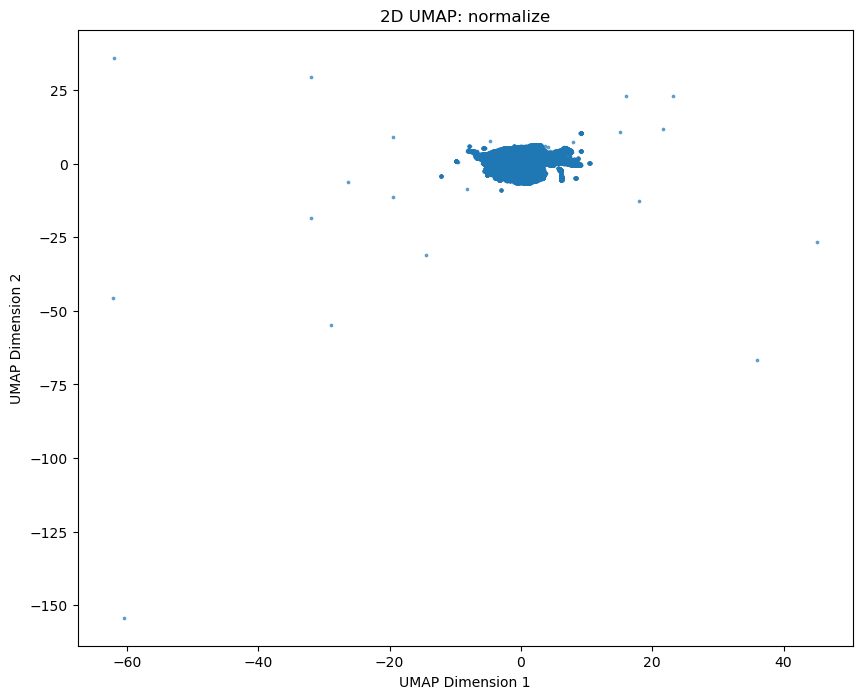

In [58]:
#Implement UMAP

def umapTest(data, name=None, neighbors=15, display=True):
    dim_reducer = UMAP(n_neighbors=neighbors, n_components=2, random_state=42)

    embed_UMAP = dim_reducer.fit_transform(data)
    if display:
        plt.figure(figsize=(10,8))
        scatter = plt.scatter(embed_UMAP[:, 0], embed_UMAP[:, 1], cmap='Spectral', s=3, alpha=0.6)
        plt.title(f'2D UMAP: {name}' if name else '2D UMAP')
        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        plt.show()
    return embed_UMAP

embed_U = umapTest(current_embeddings, current_name)

In [59]:
hdb = hdbscan.HDBSCAN()
embed_hdb = hdb.fit_predict(embed_U)

print(f"Number of clusters found: {len(set(embed_hdb))}")
print(f"Number of noise points: {sum(embed_hdb == -1)}")

Number of clusters found: 2066
Number of noise points: 26004


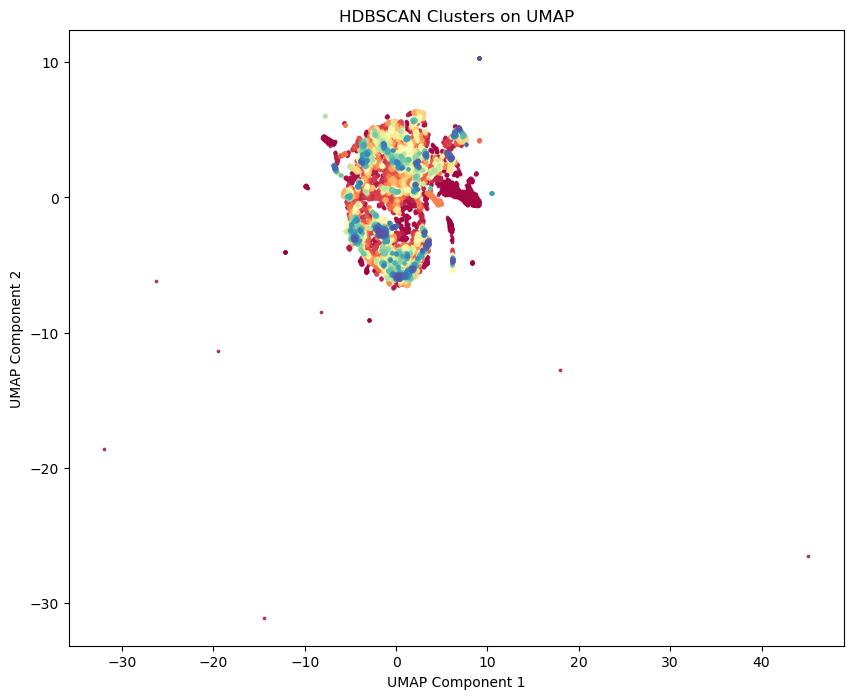

In [60]:
plt.figure(figsize=(10, 8))
unique = np.unique(embed_hdb)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique)))
for k, color in zip(unique, colors):
    mask = (embed_hdb == k)
    if k != -1:  # Exclude noise
        plt.scatter(
            embed_U[mask, 0],
            embed_U[mask, 1],
            c=[color], 
            label=f'Cluster {k}', 
            s=3, 
            alpha=0.7
    )


#plt.legend(loc='upper right', markerscale=5, fontsize='small', title='Clusters')
plt.title("HDBSCAN Clusters on UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

In [26]:

# Get the user's favorite book and genre
#fav_book = input('Enter your favorite book name: ')  # Example: "Rage of Angels"
#fav_genre = input('What is your favorite genre: ')  # Example: "Thriller"


def user_input(book, genre):
    # Combine the favorite book and genre to form a user input
    usr_input = book + ": " + genre


    # Tokenize user input and generate embedding
    tokenized_input = tokenizer(
        usr_input,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to('cuda')
    return tokenized_input

#user_tokens = user_input(fav_book, fav_genre)

In [156]:
def get_answer(tokens):
    user_embedding = book_model(**tokens)
    hidden_states = user_embedding.last_hidden_state  # Shape: (batch_size, seq_len, hidden_dim)
    usr_embeddings = hidden_states.mean(dim=1)  # Mean pooling across tokens
    ue = usr_embeddings.detach().cpu().numpy()
    norm_ue = np.vstack(ue)

    norm_ue = normalize(norm_ue)

    # Calculate cosine similarity between the user's input embedding and all book embeddings
    similarity_scores = cosine_similarity(norm_ue, current_embeddings).flatten()

    # Get the top 5 most similar books
    # top_indices = similarity_scores.argsort()[-5:][::-1]  # Indices of the top 5 books
    df["Similarity"] = similarity_scores.T
    

In [157]:
def get_scores(data, df1, genre):
    total_rec = df1[df1['Category'].str.contains(genre)]
    total_genre = data[data['Category'].str.contains(genre)]
    precision = (len(total_rec) / len(df1)) * 100
    recall = (len(total_rec) / len(total_genre)) * 100
    f1_score = ((2*precision*recall) / (precision + recall)) * 100 
    top_result = data[data['Category'].str.contains(genre)].iloc[0]
    for i in range(len(data)):
        if data.iloc[i]['Title'] == top_result['Title']:
            mrr = (1 / i+1) / len(df1)
            return [precision, recall, f1_score, mrr]
    mrr = (1 / len(data)) / len(df1)
    return [precision, recall, f1_score, mrr]

In [ ]:
def llm_routine():
    book = input('Enter your favorite book name: ')  # Example: "Rage of Angels"
    genre = input('What is your favorite genre: ')  # Example: "Thriller"
    print(f'Book: {book}, Genre: {genre}')
    get_answer(user_input(book, genre))
    print('Recommended')
    recommended_book_val = df['Similarity'].max()
    above_threshold = df[recommended_book_val - df['Similarity'] > 0.08]
    recommended_books = df.drop(above_threshold.index).sort_values(by="Similarity", ascending=False).head(10)
    print(f'Total Number of Results: {len(recommended_books)}')
    display(recommended_books[["Title", "Category", "Similarity"]].head(10))
    return get_scores(df, recommended_books, genre)
 

In [ ]:
def test_routine():
    p_sum = []

    for i in range(3):
        print(f'Trial {i+1}')
        values = llm_routine()
        print(f'Precision: {values[0]:.2f}, '
          f'\nRecall: {values[1]:.2f}, '
          f'\nF1 Score: {values[2]:.2f}'
          f'\nMRR: {values[3]:.2f}')
        p_sum.append(values[0])
        print()
        
    print(f'\nMAP: {(sum(p_sum) / len(p_sum)):.2f}')

#test_routine()

Trial 1
Book: The Hobbit, Genre: Fantasy
Recommended
Total Number of Results: 10


,Title,Category,Similarity
43146,The Magician's Nephew,"Juvenile Fiction , Fantasy & Magic",0.664027
53712,"Step into Narnia: A Journey Through The Lion, ...","Juvenile Nonfiction , Literary Criticism & Col...",0.661615
48342,The Lord of the Rings (Movie Art Cover),"Fiction , Fantasy , Epic",0.657866
82489,Watch Out for Jabba the Hutt! (Star Wars: Clon...,"Juvenile Fiction , Science Fiction",0.648745
38445,The Last of the Really Great Whangdoodles,"Juvenile Fiction , Fantasy & Magic",0.648700
31279,Aladdin and Other Favorite Arabian Nights Stor...,"Juvenile Fiction , Fantasy & Magic",0.645968
30882,The Story of King Arthur (Dover Children's Thr...,"Juvenile Fiction , Legends, Myths, Fables , Ar...",0.644190
41776,The Sorcerer's Companion: A Guide to the Magic...,"Social Science , Folklore & Mythology",0.642043
92988,The Origins of Tolkien's Middle-earth For Dummies,"Fiction , Fantasy",0.640838
98713,Ophelia Joined the Group Maidens Who Don't Flo...,"Computers , Web , Social Media",0.635014


Precision: 50.00, 
Recall: 0.39, 
F1 Score: 78.00
MRR: 0.10
Trial 2
Book: Mac OS, Genre: Computers
Recommended
Total Number of Results: 10


,Title,Category,Similarity
4549,Windows 95 for Dummies,"Computers , Operating Systems , Windows Desktop",0.563259
93615,Learning the UNIX Operating System (In a Nutsh...,"Computers , Operating Systems , UNIX",0.523391
83610,vi Editor Pocket Reference (Pocket Reference (...,"Computers , Operating Systems , UNIX",0.514894
90796,"Switching to the Mac: The Missing Manual, Leop...","Computers , Operating Systems , Apple (Mac OS ...",0.512271
102630,Windows 2000 Administration in a Nutshell: A D...,"Computers , Operating Systems , Windows Desktop",0.511975
83203,Mac OS X Snow Leopard For Dummies,"Computers , Operating Systems , Macintosh",0.511455
68032,MAC OS X 10.5 Leopard: Visual Quickstart Guide,"Computers , Operating Systems , Macintosh",0.510954
89551,"Switching to the Mac: The Missing Manual, Snow...","Computers , Hardware , Personal Computers , Ma...",0.510469
89598,Macs All-in-One For Dummies,"Computers , Hardware , Personal Computers , Ma...",0.510252
69519,Mac OS X Leopard: The Missing Manual,"Computers , Operating Systems , Apple (Mac OS ...",0.506803


Precision: 100.00, 
Recall: 1.21, 
F1 Score: 238.95
MRR: 0.10
Trial 3
Book: Spider Man, Genre: Comics
Recommended
Total Number of Results: 7


,Title,Category,Similarity
39133,Ultimate Annuals - Volume 1,"Young Adult Fiction , Comics & Graphic Novels ...",0.622767
39113,Ultimate Annuals Volume 2,"Comics & Graphic Novels , Superheroes",0.596043
39260,"Fantastic Four, Vol. 1: All for One","Juvenile Fiction , Comics & Graphic Novels , S...",0.583869
27199,"Like Father, Like Daughter (Spider-Girl, Vol. 2)","Juvenile Fiction , Comics & Graphic Novels , S...",0.557925
39126,Civil War: Heroes For Hire,"Comics & Graphic Novels , Superheroes",0.551897
39108,Spider-Man: Saga of the Sandman,"Young Adult Fiction , Comics & Graphic Novels ...",0.549790
82489,Watch Out for Jabba the Hutt! (Star Wars: Clon...,"Juvenile Fiction , Science Fiction",0.548191


Precision: 85.71, 
Recall: 3.49, 
F1 Score: 670.39
MRR: 0.14

MAP: 78.57

